<a href="https://colab.research.google.com/github/arturrur/mc853/blob/using-KNN-imputer/fun%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# Importing necessary libraries

import pandas as pd                       # For data manipulation and analysis
import numpy as np                        # For numerical computing
import time                               # For tracking time
import math                               # For mathematical operations
import warnings                           # For managing warnings

import shap                               # For SHAP (SHapley Additive exPlanations) values

import imblearn                           # For dealing with imbalanced datasets
from imblearn.over_sampling import RandomOverSampler   # For oversampling
from imblearn.under_sampling import RandomUnderSampler # For undersampling


import seaborn as sns                     # For statistical data visualization
import matplotlib.pyplot as plt           # For creating visualizations
import matplotlib.patches as mpatches     # For drawing patches in plots
import matplotlib.colors as mcolors       # For defining custom colors in plots
import matplotlib.ticker as ticker        # For formatting tick marks on plots
from matplotlib.ticker import FuncFormatter         # For custom tick formatting
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler      # For feature scaling
from sklearn.model_selection import (StratifiedKFold,
                                     GridSearchCV) # For splitting data into train and test sets

from sklearn.metrics import (roc_auc_score,           # For evaluating model performance
                             recall_score,
                             make_scorer,
                             balanced_accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             precision_recall_curve,
                             f1_score)

from sklearn.svm import SVC                           # For Support Vector Classifier
from sklearn.linear_model import LogisticRegression   # For Logistic Regression Classifier
from sklearn.ensemble import (RandomForestClassifier, # For ensemble classifiers
                              GradientBoostingClassifier,
                              BaggingClassifier)
from sklearn.neighbors import KNeighborsClassifier # For KNN

from sklearn.neural_network import MLPClassifier      # For Multi-layer Perceptron Classifier

from sklearn.impute import KNNImputer

import re
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter

In [44]:
# Set the number of folds for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Set the number of kfolds for grid search
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# Choice of the best hyperparameters through balanced accuracy metric
perf = balanced_accuracy_score

# Set preprocessing: StandardScaler for feature standardization
preprocessing = StandardScaler()

# Initialize KNNImputer with the specified number of neighbors
imputer = KNNImputer(n_neighbors=3)

In [45]:
# Define a dictionary containing various classification algorithms and their parameters used in grid search

algorithms = {
    # K-Nearest Neighbors Classifier
    'knn': (KNeighborsClassifier(), {
        'n_neighbors': [1, 5, 10],
        'p':[1, 2],
        'weights': ('uniform', 'distance')}),

    # Random Forest Classifier
    'random_forest': (RandomForestClassifier(random_state=0), {
        'n_estimators': [10, 100, 200],
        'max_depth': [10, 50],
        'min_samples_split': [2, 10, 30],
        }),

    # Logistic Regression Classifier
    'logistic_regression': (LogisticRegression(), {
        'class_weight': ('balanced', {0:1, 1:2}, {0:1, 1:3})}),
}

In [46]:
def data_sample(X, y):
    '''
    Receives a set of features and target feature separately.
    Returns balanced data, with the same number of samples in both classes.
    If the minority class is less than 5%, applies oversampling and undersampling.
    Otherwise, applies only undersampling.
    Parameters:
        X : array-like, shape (n_samples, n_features)
            The feature matrix.
        y : array-like, shape (n_samples,)
            The target variable.

    Returns:
        X_resampled : array-like, shape (n_samples_resampled, n_features)
            The resampled feature matrix.
        y_resampled : array-like, shape (n_samples_resampled,)
            The resampled target variable.
    '''

    # Define sampling strategies
    undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
    oversample = RandomOverSampler(sampling_strategy=0.2, random_state=1)

    # Identify the minority class
    count_1 = (y == 1).sum()
    count_0 = (y == 0).sum()
    count_min = min(count_0, count_1)
    count_max = max(count_0, count_1)


    # Calculate the percentage of the minority class compared to the total number of instances
    ratio = (count_min / count_max)

    # If the minority class is more than 60% of the majority class, do not apply any resampling technique
    if ratio > 0.6:
        X_resampled, y_resampled = X, y

    # Check if the percentage of class 1 is at least 5% of the total number of instances
    # If it is less than 5%, apply both over and under sampling
    else:
        if ratio <= 0.2:
            X_resampled, y_resampled = oversample.fit_resample(X, y)
            X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

        # Otherwise, apply only undersampling
        else:
            X_resampled, y_resampled = undersample.fit_resample(X, y)

    return X_resampled, y_resampled


In [47]:
def impute_missing(data, n_neighbors=3):
    """
    Impute missing values using the K-nearest neighbors algorithm.

    Parameters:
        data (pd.DataFrame): Input DataFrame with missing values.
        n_neighbors (int, optional): Number of neighbors to use for imputation. Defaults to 3.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed using KNN.
    """
    # Initialize KNNImputer with the specified number of neighbors
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Perform imputation
    imputed_data = imputer.fit_transform(data)

    # Convert the imputed array back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=data.columns, index=data.index)

    return imputed_df


In [54]:
from sklearn.metrics import precision_score

def evaluate_cv(data):
    '''
    Receives data to be evaluated and returns the average performance inside cross-validation, using 3 metrics.
    Applies over-under sampling to get balanced datasets and standardizes features.

    Parameters:
    data : DataFrame
        The dataset containing features and the target variable.

    Returns:
    df : DataFrame
        A DataFrame containing the mean and standard deviation of each algorithm's performance across 5-fold cross-validation.
        The performance metrics include AUC (mean and standard deviation), sensitivity (mean and standard deviation),
        specificity (mean and standard deviation), prec_n (mean and standard deviation), and prec_p (mean and standard deviation).
    '''
    # Record the start time
    start_time = time.time()

    # Identify the target column
    target_feature = data.columns[-1]

    # Separate features (X) and target (y)
    X = data.drop(columns=[target_feature])
    y = data[target_feature]

    # Initialize dictionaries to store metrics for each algorithm
    sen = {}
    spe = {}
    auc = {}
    prec_n = {}  # Negative precision
    prec_p = {}  # Positive precision

    for algorithm in algorithms.keys():
        sen[algorithm] = []
        spe[algorithm] = []
        auc[algorithm] = []
        prec_n[algorithm] = []
        prec_p[algorithm] = []

    # Dict to save the best hyperparams on each fold
    best_params_summary = {alg: [] for alg in algorithms.keys()}

    for algorithm, (clf, parameters) in algorithms.items():
      best = GridSearchCV(clf, parameters, cv=gskf, scoring=(make_scorer(perf)))

      # Iterate through each round of the cross-validation
      for train, test in kf.split(X, y):
        # Allocate train and test data
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        # # Apply over-under sampling
        X_train, y_train = data_sample(X_train, y_train)

        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        # Standardize features
        X_train = preprocessing.fit_transform(X_train)
        X_test = preprocessing.transform(X_test)

        # Find best hyperparameters
        best.fit((X_train), y_train)

        # Saving the best of this fold
        best_params_summary[algorithm].append(best.best_params_)

        # Make predictions for the test data
        y_pred = best.predict(X_test)

        # Calculate sensitivity and specificity
        recallscore = recall_score(y_test, y_pred, labels=[0, 1], average=None)
        sen[algorithm].append(recallscore[1])
        spe[algorithm].append(recallscore[0])

        # Calculate precision for each class
        prec_score = precision_score(y_test, y_pred, labels=[0, 1], average=None)
        prec_n[algorithm].append(prec_score[0])
        prec_p[algorithm].append(prec_score[1])

        # Calculate the area under the ROC curve
        aucscore = roc_auc_score(y_test, (best.predict_proba((X_test)))[:, 1])
        auc[algorithm].append(aucscore)

    final_best_params = {}

    # Choose the most common hyperparams across all folds
    for alg, params_list in best_params_summary.items():
          most_common = Counter([frozenset(p.items()) for p in params_list]).most_common(1)[0][0]
          final_best_params[alg] = dict(most_common)

    # Create a DataFrame with the mean and standard deviation of each algorithm's performance across 5 folds
    df = pd.DataFrame(columns=list(algorithms.keys()))

    df.loc['auc (mean)'] = [np.mean(auc['knn']), np.mean(auc['random_forest']), np.mean(auc['logistic_regression'])]
    df.loc['auc (stdev)'] = [np.std(auc['knn']), np.std(auc['random_forest']), np.std(auc['logistic_regression'])]

    df.loc['rcl_1 (mean)'] = [np.mean(sen['knn']), np.mean(sen['random_forest']), np.mean(sen['logistic_regression'])]
    df.loc['rcl_1 (stdev)'] = [np.std(sen['knn']), np.std(sen['random_forest']), np.std(sen['logistic_regression'])]

    df.loc['rcl_0 (mean)'] = [np.mean(spe['knn']), np.mean(spe['random_forest']), np.mean(spe['logistic_regression'])]
    df.loc['rcl_0 (stdev)'] = [np.std(spe['knn']), np.std(spe['random_forest']), np.std(spe['logistic_regression'])]

    df.loc['prc_1 (mean)'] = [np.mean(prec_p['knn']), np.mean(prec_p['random_forest']), np.mean(prec_p['logistic_regression'])]
    df.loc['prc_1 (stdev)'] = [np.std(prec_p['knn']), np.std(prec_p['random_forest']), np.std(prec_p['logistic_regression'])]

    df.loc['prc_0 (mean)'] = [np.mean(prec_n['knn']), np.mean(prec_n['random_forest']), np.mean(prec_n['logistic_regression'])]
    df.loc['prc_0 (stdev)'] = [np.std(prec_n['knn']), np.std(prec_n['random_forest']), np.std(prec_n['logistic_regression'])]


    # Set caption for DataFrame
    df = df.style.set_caption('Average performance and standard deviation among 5-fold cross-validation')

    # Record the end time
    end_time = time.time()

    # Calculate the time taken
    total_time = end_time - start_time

    # Print the selected hyperparameters
    print("Best Hyperparams:")
    print("KNN: ", str(final_best_params['knn']))
    print("Random Forest: ", str(final_best_params['random_forest']))
    print("Logistic Regression: ", str(final_best_params['logistic_regression']))

    # Print the total time taken to run cross-validation
    print(f"Total time taken to run cross-validation: {total_time:.2f} seconds")

    return df

In [72]:
from sklearn.metrics import precision_score

def evaluate_external(data, data_test):
    '''
    Receives data and data_test to be evaluated and returns the average performance, using 3 metrics.
    Applies over-under sampling to get balanced datasets and standardizes features.

    Parameters:
    data : DataFrame
        The training dataset containing features and the target variable.
    data_test : DataFrame
        The test dataset containing features and the target variable.

    Returns:
    df : DataFrame
        A DataFrame containing the mean performance of each algorithm across external validation.
        The performance metrics include AUC (mean), sensitivity (mean), specificity (mean), prec_n (mean), and prec_p (mean).
    '''
    # Record the start time
    start_time = time.time()

    # Identify the target column
    target_feature = data.columns[-1]

    # Separate features (X) and target (y) for training data
    X = data.drop(columns=[target_feature])
    y = data[target_feature]

    # Separate features (X) and target (y) for test data
    X_test = data_test.drop(columns=[target_feature])
    y_test = data_test[target_feature]

    # Initialize dictionaries to store metrics for each algorithm
    sen = {}
    spe = {}
    auc = {}
    prec_n = {}  # Negative precision
    prec_p = {}  # Positive precision

    for algorithm in algorithms.keys():
        sen[algorithm] = []
        spe[algorithm] = []
        auc[algorithm] = []
        prec_n[algorithm] = []
        prec_p[algorithm] = []

    # Apply over-under sampling to training data
    X_train, y_train = data_sample(X, y)

    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Apply preprocessing to both training and test data
    X_train = preprocessing.fit_transform(X_train)
    X_test = preprocessing.transform(X_test)

    # For each algorithm
    for algorithm, (clf, parameters) in algorithms.items():
        # Train model
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=(make_scorer(perf)))
        best.fit(X_train, y_train)

        print("Best hyperparameters found:", best.best_params_)
        y_pred = best.predict(X_test)


        # METRICS
        # Calculate sensitivity and specificity
        recallscore = recall_score(y_test, y_pred, labels=[0, 1], average=None)
        sen[algorithm].append(recallscore[1])
        spe[algorithm].append(recallscore[0])

        # Calculate precision for each class
        prec_score = precision_score(y_test, y_pred, labels=[0, 1], average=None)
        prec_n[algorithm].append(prec_score[0])
        prec_p[algorithm].append(prec_score[1])

        # Calculate the area under the ROC curve
        aucscore = roc_auc_score(y_test, (best.predict_proba((X_test)))[:, 1])
        auc[algorithm].append(aucscore)

        fig, ax = plt.subplots(figsize=(3, 3))
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
        disp.plot(ax=ax)
        disp.ax_.set_title(f"{algorithm}")
        plt.show()


    # Create a DataFrame with the mean performance of each algorithm across the external validation
    df = pd.DataFrame(columns=list(algorithms.keys()))

    df.loc['auc (mean)'] = [np.mean(auc['knn']), np.mean(auc['random_forest']), np.mean(auc['logistic_regression'])]

    df.loc['rcl_1 (mean)'] = [np.mean(sen['knn']), np.mean(sen['random_forest']), np.mean(sen['logistic_regression'])]

    df.loc['rcl_0 (mean)'] = [np.mean(spe['knn']), np.mean(spe['random_forest']), np.mean(spe['logistic_regression'])]

    df.loc['prc_1 (mean)'] = [np.mean(prec_p['knn']), np.mean(prec_p['random_forest']), np.mean(prec_p['logistic_regression'])]

    df.loc['prc_0 (mean)'] = [np.mean(prec_n['knn']), np.mean(prec_n['random_forest']), np.mean(prec_n['logistic_regression'])]

    # Set caption for DataFrame
    df = df.style.set_caption('Performance for external validation')

    # Record the end time
    end_time = time.time()

    # Calculate the time taken
    total_time = end_time - start_time

    # Print the total time taken to run external-validation
    print(f"Total time taken to run external-validation: {total_time:.2f} seconds")

    return df

Cross-validation usando dados treino

In [55]:
df = pd.read_csv('https://raw.githubusercontent.com/arturrur/mc853/refs/heads/using-KNN-imputer/data/training/treino.csv')

evaluate_cv(df)

Best Hyperparams:
KNN:  {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Random Forest:  {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 2}
Logistic Regression:  {'class_weight': 'balanced'}
Total time taken to run cross-validation: 140.01 seconds


,knn,random_forest,logistic_regression
auc (mean),0.800228,0.847621,0.847813
auc (stdev),0.010038,0.006069,0.002878
rcl_1 (mean),0.666925,0.690968,0.755099
rcl_1 (stdev),0.033901,0.032762,0.015737
rcl_0 (mean),0.781584,0.829012,0.780041
rcl_0 (stdev),0.013495,0.008854,0.008907
prc_1 (mean),0.261093,0.318438,0.284126
prc_1 (stdev),0.013009,0.011712,0.004215
prc_0 (mean),0.953110,0.958743,0.965021
prc_0 (stdev),0.004285,0.004028,0.001788


Validação externa do modelo

Best hyperparameters found: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


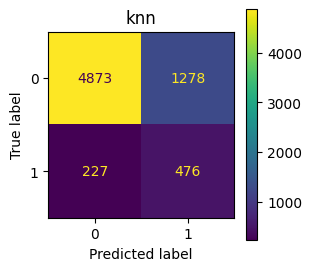

Best hyperparameters found: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 200}


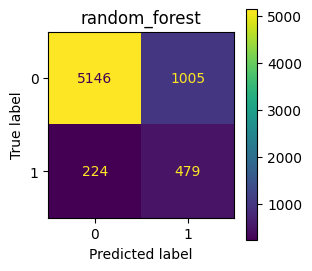

Best hyperparameters found: {'class_weight': 'balanced'}


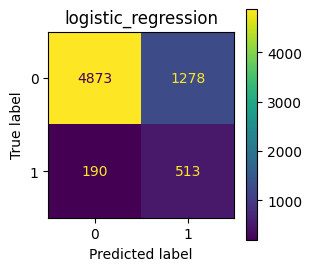

Total time taken to run external-validation: 33.70 seconds


,knn,random_forest,logistic_regression
auc (mean),0.805300,0.850098,0.852553
rcl_1 (mean),0.677098,0.681366,0.729730
rcl_0 (mean),0.792229,0.836612,0.792229
prc_1 (mean),0.271380,0.322776,0.286432
prc_0 (mean),0.955490,0.958287,0.962473


In [73]:
df_test = pd.read_csv('https://raw.githubusercontent.com/arturrur/mc853/refs/heads/using-KNN-imputer/data/test/teste19.csv')

evaluate_external(df, df_test)